# **18.FORECASTING_AIRLINES**

In [55]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
airlines= pd.read_excel("Airlines+Data.xlsx")

airlines

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


In [57]:
airlines1=airlines.copy()

In [58]:
airlines1.head(3)

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132


In [59]:
airlines1.isnull().sum()

Month         0
Passengers    0
dtype: int64

In [60]:
airlines1 = airlines1.set_index('Month')

**Visualization**

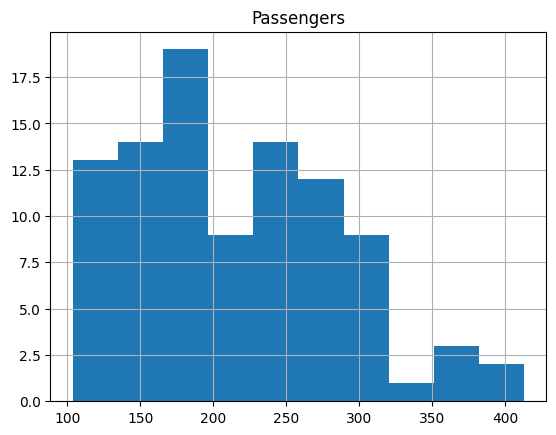

In [61]:
airlines1.hist()
plt.show()

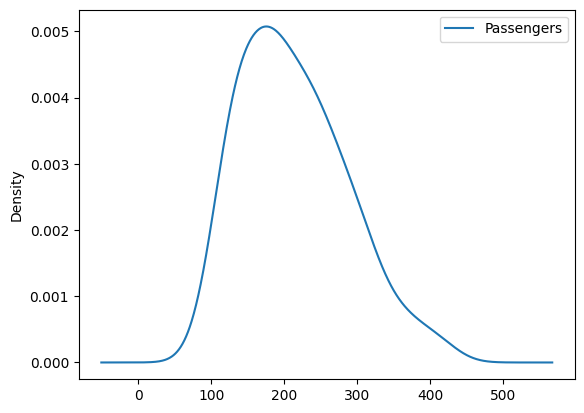

In [62]:
airlines1.plot(kind='kde')
plt.show()

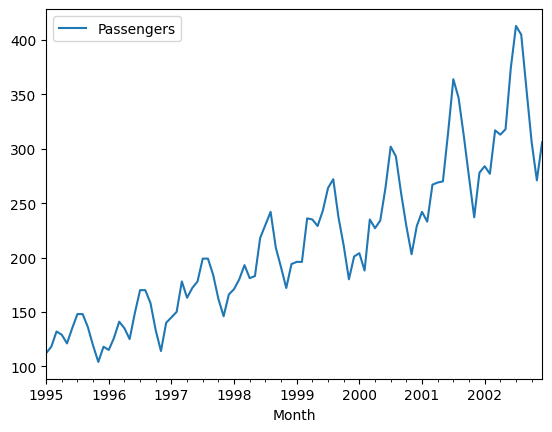

In [63]:
airlines1.plot()
plt.show()

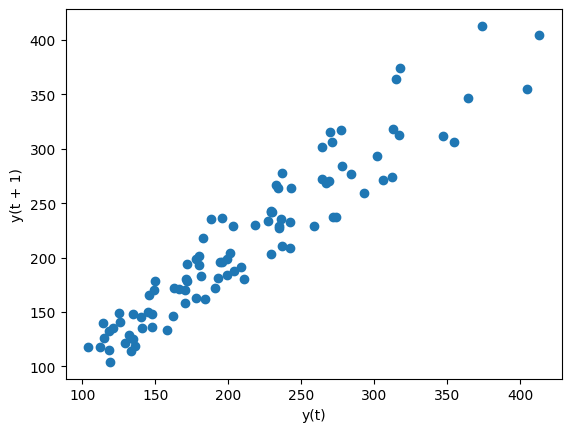

In [64]:
from pandas.plotting import lag_plot
lag_plot(airlines1)
plt.show()

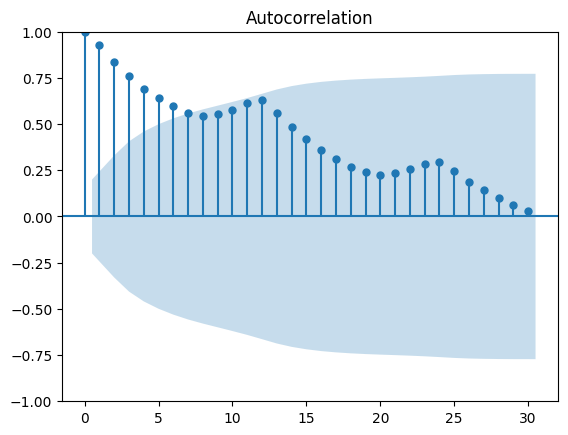

In [65]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(airlines1,lags=30)
plt.show()

**UpSampling**

In [66]:
upsampled = airlines1.resample('M').mean()
upsampled

,Passengers
Month,
1995-01-31,112.0
1995-02-28,118.0
1995-03-31,132.0
1995-04-30,129.0
1995-05-31,121.0
...,...
2002-08-31,405.0
2002-09-30,355.0
2002-10-31,306.0


            Passengers
Month                 
1995-01-31       112.0
1995-02-28       118.0
1995-03-31       132.0
1995-04-30       129.0
1995-05-31       121.0
1995-06-30       135.0
1995-07-31       148.0
1995-08-31       148.0
1995-09-30       136.0
1995-10-31       119.0
1995-11-30       104.0
1995-12-31       118.0
1996-01-31       115.0
1996-02-29       126.0
1996-03-31       141.0


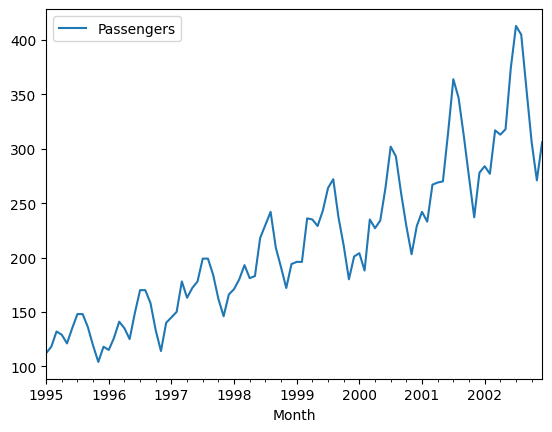

In [67]:
interpolated = upsampled.interpolate(method='linear') 
print(interpolated.head(15))
interpolated.plot()
plt.show()

In [68]:
interpolated

,Passengers
Month,
1995-01-31,112.0
1995-02-28,118.0
1995-03-31,132.0
1995-04-30,129.0
1995-05-31,121.0
...,...
2002-08-31,405.0
2002-09-30,355.0
2002-10-31,306.0


**Tranformations**

**Square Root Transform**

In [69]:
from pandas import DataFrame
from numpy import sqrt

In [70]:
dataframe = DataFrame(airlines1.values)
dataframe.columns = ['Passengers']
dataframe['Passengers'] = sqrt(dataframe['Passengers'])  

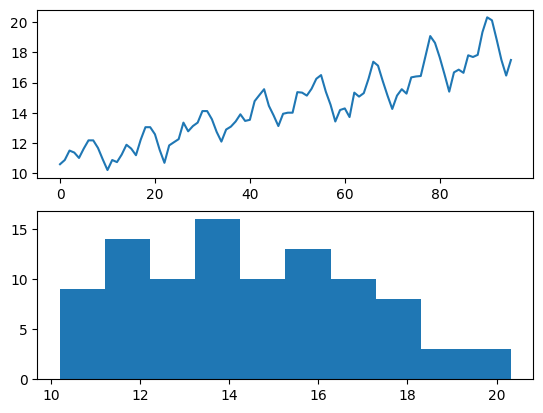

In [71]:
# line plot
plt.subplot(211)
plt.plot(dataframe['Passengers'])
# histogram
plt.subplot(212)
plt.hist(dataframe['Passengers'])
plt.show() 

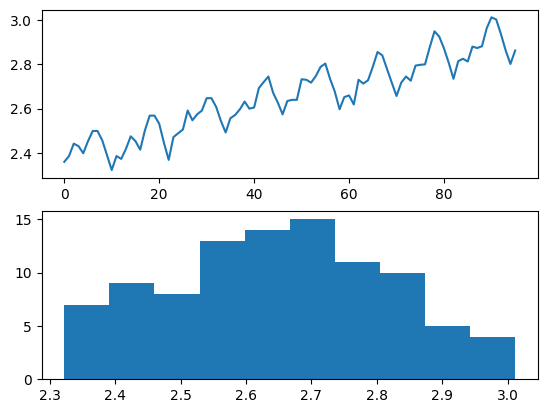

In [72]:
from numpy import log
dataframe['Passengers'] = log(dataframe['Passengers'])

# line plot
plt.subplot(211)
plt.plot(dataframe['Passengers'])
# histogram
plt.subplot(212)
plt.hist(dataframe['Passengers'])
plt.show() 

**Moving Average**

In [73]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing  

In [74]:
Train = interpolated.head(84)
Test = interpolated.tail(12)

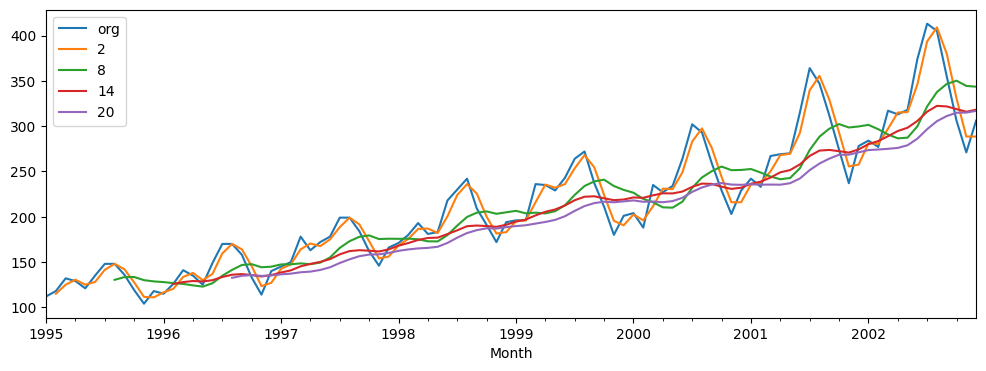

In [75]:
plt.figure(figsize=(12,4))
interpolated.Passengers.plot(label="org")
for i in range(2,24,6):
    interpolated["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best') 

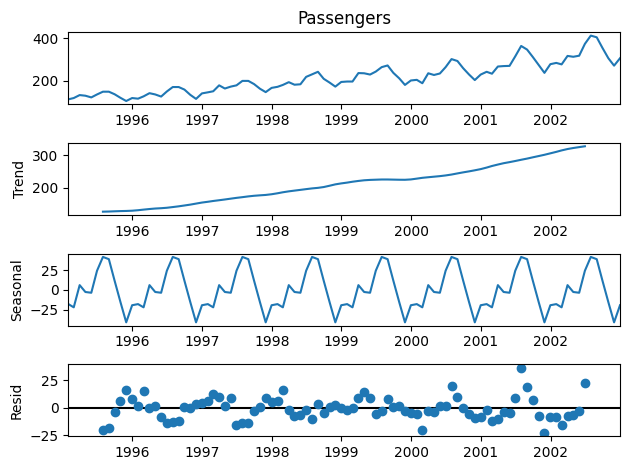

In [76]:
decompose_ts_add = seasonal_decompose(interpolated.Passengers,period=12)
decompose_ts_add.plot()
plt.show() 

**ACF plots and PACF plots**

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


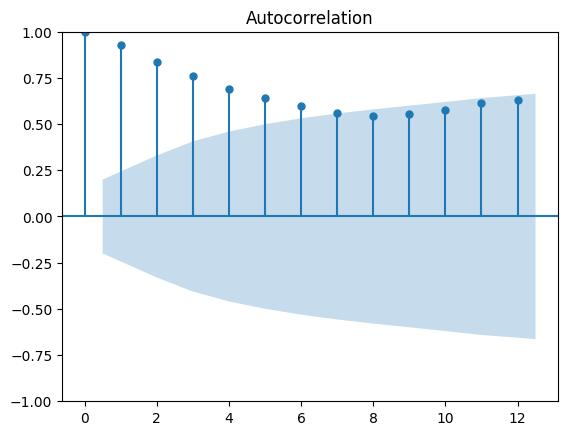

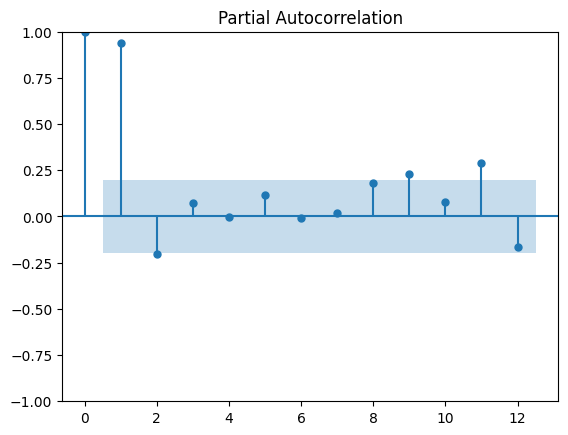

In [77]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(interpolated.Passengers,lags=12)
tsa_plots.plot_pacf(interpolated.Passengers,lags=12)
plt.show()

**Evaluation Metric MAPE**

In [78]:
import warnings
warnings.filterwarnings("ignore")

In [79]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp) 

In [80]:
#Simple Exponential Method¶

interpolated["Passengers"] = interpolated["Passengers"].astype('double') 
ses_model = SimpleExpSmoothing(Train["Passengers"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Passengers)

13.411274740513823

In [81]:
#Holt method

holt_model = Holt(Train["Passengers"]).fit(smoothing_level=0.1, smoothing_slope=0.2)
pred_holt = holt_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_holt,Test.Passengers)

10.887678734005219

In [82]:
holtw_add = ExponentialSmoothing(Train["Passengers"],seasonal="add",trend="add",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.2) #add the trend to the model
pred_holtw_add = holtw_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_holtw_add,Test.Passengers)

2.6352759456348553

In [83]:
holt_mul = ExponentialSmoothing(Train["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.2) 
pred_holt_mul= holt_mul.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_holt_mul,Test.Passengers)

2.15468672154073

**Final Model by combining train and test**

In [84]:
holt_mul_final = ExponentialSmoothing(interpolated["Passengers"],seasonal="mul",trend="add",seasonal_periods=10).fit()


In [85]:
holt_mul_final.forecast(10) 

2003-01-31    317.030134
2003-02-28    323.394651
2003-03-31    328.485828
2003-04-30    332.151130
2003-05-31    336.586121
2003-06-30    331.899614
2003-07-31    318.957637
2003-08-31    315.885183
2003-09-30    314.439842
2003-10-31    327.166938
Freq: M, dtype: float64

In [86]:
interpolated.reset_index(inplace=True)

In [87]:
interpolated['t'] = 1

In [88]:
for i,row in interpolated.iterrows():
  interpolated['t'].iloc[i] = i+1

In [89]:
interpolated['t_sq'] = (interpolated['t'])**2

interpolated

,Month,Passengers,t,t_sq
0,1995-01-31,112.0,1,1
1,1995-02-28,118.0,2,4
2,1995-03-31,132.0,3,9
3,1995-04-30,129.0,4,16
4,1995-05-31,121.0,5,25
...,...,...,...,...
91,2002-08-31,405.0,92,8464
92,2002-09-30,355.0,93,8649
93,2002-10-31,306.0,94,8836
94,2002-11-30,271.0,95,9025


In [90]:
from datetime import datetime,time
interpolated["month"] = interpolated.Month.dt.strftime("%b")
interpolated["year"] = interpolated.Month.dt.strftime("%Y") 

In [91]:
interpolated

,Month,Passengers,t,t_sq,month,year
0,1995-01-31,112.0,1,1,Jan,1995
1,1995-02-28,118.0,2,4,Feb,1995
2,1995-03-31,132.0,3,9,Mar,1995
3,1995-04-30,129.0,4,16,Apr,1995
4,1995-05-31,121.0,5,25,May,1995
...,...,...,...,...,...,...
91,2002-08-31,405.0,92,8464,Aug,2002
92,2002-09-30,355.0,93,8649,Sep,2002
93,2002-10-31,306.0,94,8836,Oct,2002
94,2002-11-30,271.0,95,9025,Nov,2002


In [92]:
months = pd.get_dummies(interpolated['month']) 

In [93]:
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
data = pd.concat([interpolated,months],axis=1)

data

,Month,Passengers,t,t_sq,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1995-01-31,112.0,1,1,Jan,1995,1,0,0,0,0,0,0,0,0,0,0,0
1,1995-02-28,118.0,2,4,Feb,1995,0,1,0,0,0,0,0,0,0,0,0,0
2,1995-03-31,132.0,3,9,Mar,1995,0,0,1,0,0,0,0,0,0,0,0,0
3,1995-04-30,129.0,4,16,Apr,1995,0,0,0,1,0,0,0,0,0,0,0,0
4,1995-05-31,121.0,5,25,May,1995,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-31,405.0,92,8464,Aug,2002,0,0,0,0,0,0,0,1,0,0,0,0
92,2002-09-30,355.0,93,8649,Sep,2002,0,0,0,0,0,0,0,0,1,0,0,0
93,2002-10-31,306.0,94,8836,Oct,2002,0,0,0,0,0,0,0,0,0,1,0,0
94,2002-11-30,271.0,95,9025,Nov,2002,0,0,0,0,0,0,0,0,0,0,1,0


In [94]:
data['log_passengers'] = np.log(data['Passengers'])


<Axes: xlabel='month', ylabel='year'>

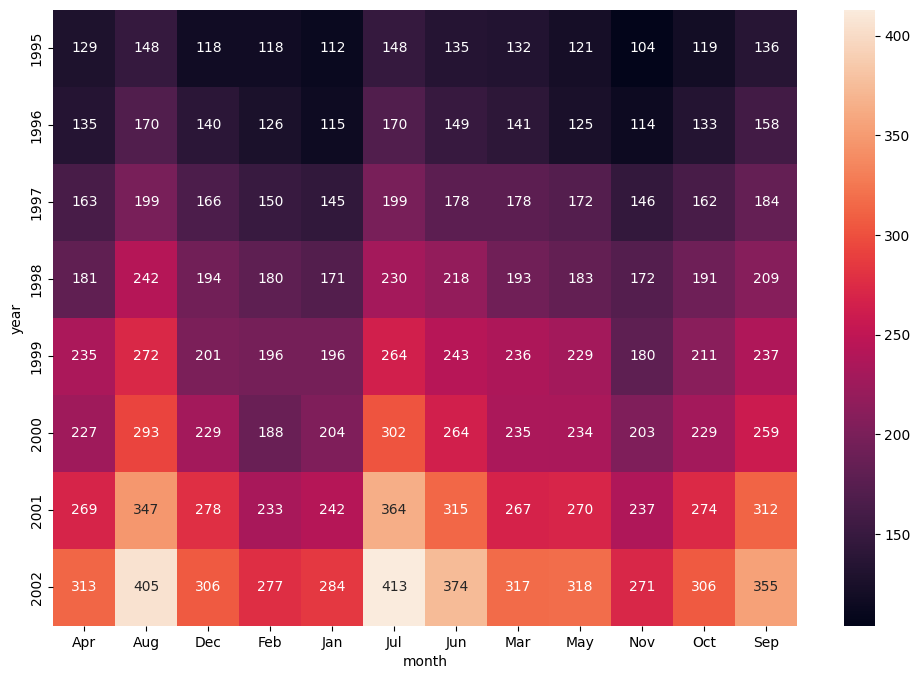

In [95]:
plt.figure(figsize=(12,8))
heatmap_y_month = pd.pivot_table(data=data,values="Passengers",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")

<Axes: xlabel='month', ylabel='Passengers'>

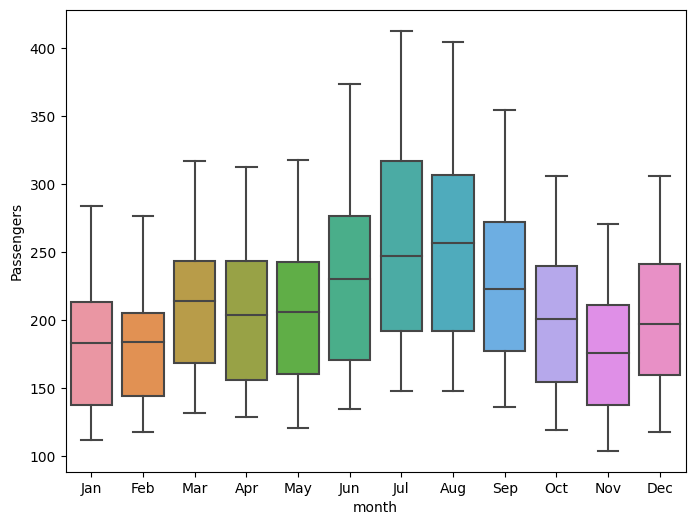

In [96]:
plt.figure(figsize=(8,6))
sns.boxplot(x="month",y="Passengers",data= data)


<Axes: xlabel='year', ylabel='Passengers'>

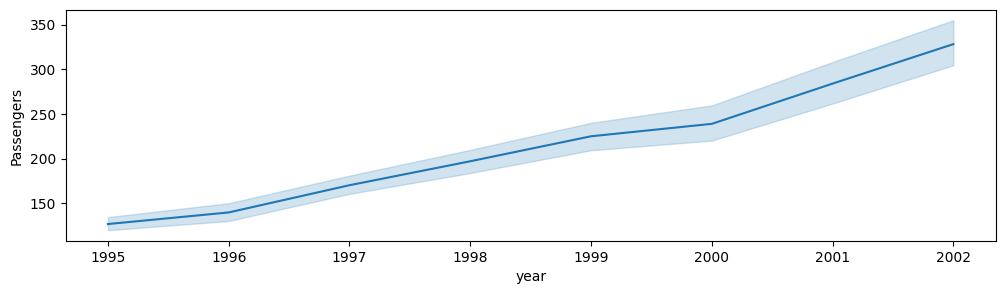

In [97]:
plt.figure(figsize=(12,3))
sns.lineplot(x="year",y="Passengers",data=data)

In [98]:
Train = data.head(84) 
Test = data.tail(12)

In [99]:
import statsmodels.formula.api as smf 

In [100]:
#Linear Model

linear_model = smf.ols('Passengers~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_linear))**2))
rmse_linear

53.19923653480278

In [101]:
#Exponential Model

Exp_mod = smf.ols('log_passengers~t',data=Train).fit()
pred_Exp = pd.Series(Exp_mod.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

46.05736110315654

In [102]:
#Quadratic Model

Quad_mod = smf.ols('Passengers~t+t_sq',data=Train).fit()
pred_Quad = pd.Series(Quad_mod.predict(Test[["t","t_sq"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_Quad))**2))
rmse_Quad

48.05188897933164

In [103]:
#Additive seasonality

add_sea_mod = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea = pd.Series(add_sea_mod.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea))**2))
rmse_add_sea

132.8197848142182

In [104]:
#Additive Seasonality Quadratic

add_sea_Quad_mod = smf.ols('Passengers~t+t_sq+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad_mod.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_sq']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

26.360817612095307

In [105]:
#Multiplicative Seasonality

Mul_sea_mod = smf.ols('log_passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea_mod.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

140.06320204708646

In [106]:
#Multiplicative Additive Seasonality

Mul_Add_sea_mod = smf.ols('log_passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea_mod.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea

10.519172544323746

In [107]:
data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
6,rmse_Mult_add_sea,10.519173
4,rmse_add_sea_quad,26.360818
1,rmse_Exp,46.057361
2,rmse_Quad,48.051889
0,rmse_linear,53.199237
3,rmse_add_sea,132.819785
5,rmse_Mult_sea,140.063202


**CONCLUSION**

Here the Multiplicative Additive Seasonality model has low rmse value hence it is the best model